In [33]:
import os
import re
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import json
import math

%matplotlib inline
%config IPCompleter.greedy=True

pd.set_option('display.max_colwidth', -1)

In [34]:
data_dir='/Users/genie/dev/projects/github/network_analysis_ticket_to_ride/data/'
destinations_path = os.path.join(data_dir,'destinations.txt')
routes_path = os.path.join(data_dir,'trainroutes.txt')

In [35]:
pattern = re.compile('\\w+')

In [36]:
Gm = nx.MultiGraph()

In [37]:
# functions

# function to calculate points from segment length
def points(distance):
    x = [0, 1, 2, 4, 7, 0, 15, 0, 21]
    return x[distance]

def inverse_weight(distance):
    return(1/distance)

# distance of path p in graph g
def distance_of_path(g, p):
    d = sum([g.edges[p[e],p[e+1]]['distance'] for e in range(len(p)-1)])
    return d

# points of path p in graph g
def points_of_path(g, p):
    d = sum([g.edges[p[e],p[e+1]]['points'] for e in range(len(p)-1)])
    return d

# return all paths between u and v in graph g up to distance min(u,v)+2
def alternate_scoring_paths_with_cutoff(g, u, v, cutoff):
    sp_length = nx.shortest_path_length(g,u,v)
    paths = nx.all_simple_paths(g, u, v, cutoff=sp_length+2)
    return list(paths)

In [38]:
# construct graph

Gm.clear()

with open(routes_path) as f:
    for line in f:
        city1, city2, distance, route_type, color, is_multi = pattern.findall(line)
        distance = int(distance)
        if(Gm.has_edge(city1,city2)==False):
            Gm.add_edge(city1, city2, key=0, distance=distance, route_type=route_type, color=color, points=points(distance), 
                   weight=distance, importance=0)

# convert multigraph to simple graph            
G = nx.Graph(Gm)

In [39]:
for n,v in sorted(Gm.degree, key=lambda x: x[1], reverse=True)[:10]:
    print('{n}-{v}'.format(n=n,v=v))

Paris-7
Kyiv-6
Frankfurt-6
Pamplona-5
Marseille-5
Sevastopol-5
Constantinople-5
Bucuresti-5
Wilno-5
Warszawa-5


In [40]:
for n,v in sorted(Gm.degree, key=lambda x: x[1], reverse=False)[:10]:
    print('{n}-{v}'.format(n=n,v=v))

Edinburgh-1
Lisboa-2
Cadiz-2
Stockholm-2
Kobenhavn-2
Barcelona-3
Brest-3
London-3
Erzurum-3
Angora-3


In [41]:
# construct shortest paths of destinations
temp=list()
with open(destinations_path) as f:
    for line in f:
        source, destination, card_points = pattern.findall(line)
        card_points=int(card_points)
        p1=list()
        points1=0
        distance1=0
        length1=0
        for p in nx.all_shortest_paths(G,source,destination,weight='weight'):
            _points=points_of_path(G,p)
            if(_points>points1):
                points1=_points
                distance1=distance_of_path(G,p)
                p1=p
                length1=len(p)
        total_points=card_points+points1
        temp.append((source,destination,card_points,length1,distance1,total_points,'-'.join(p1)))
        
destinations_df = pd.DataFrame.from_records(temp, columns=['source','destination','card_points',
                                                           'sp_length','sp_cost','sp_total_points','sp_path'])
del temp

In [42]:
#  calculate points-per-capita
destinations_df['sp_points_per_capita'] = destinations_df.apply(lambda row: round(row['sp_total_points']/row['sp_cost'],2), axis=1)

# connectivity
destinations_df['connectivity'] = destinations_df.apply(lambda row: nx.edge_connectivity(G,row['source'],row['destination']), axis=1)

In [43]:
destinations_df.sort_values(['sp_total_points'],ascending=False).head(10)

,source,destination,card_points,sp_length,sp_cost,sp_total_points,sp_path,sp_points_per_capita,connectivity
42,Palermo,Moskva,20,7,20,54,Palermo-Smyrna-Constantinople-Bucuresti-Kyiv-Smolensk-Moskva,2.70,3
43,Kobenhavn,Erzurum,21,8,21,53,Kobenhavn-Essen-Berlin-Wien-Budapest-Bucuresti-Sevastopol-Erzurum,2.52,2
45,Cadiz,Stockholm,21,8,21,50,Cadiz-Madrid-Pamplona-Paris-Frankfurt-Essen-Kobenhavn-Stockholm,2.38,2
41,Brest,Petrograd,20,7,20,50,Brest-Paris-Frankfurt-Berlin-Warszawa-Wilno-Petrograd,2.50,3
40,Lisboa,Danzig,20,7,20,50,Lisboa-Madrid-Pamplona-Paris-Frankfurt-Berlin-Danzig,2.50,2
44,Edinburgh,Athina,21,9,20,48,Edinburgh-London-Dieppe-Paris-Zurich-Venezia-Roma-Brindisi-Athina,2.40,1
39,Frankfurt,Smolensk,13,5,13,32,Frankfurt-Berlin-Warszawa-Wilno-Smolensk,2.46,3
38,Amsterdam,Wilno,12,5,12,29,Amsterdam-Frankfurt-Berlin-Warszawa-Wilno,2.42,4
37,Berlin,Moskva,12,5,12,29,Berlin-Warszawa-Wilno-Smolensk-Moskva,2.42,3
32,Essen,Kyiv,10,4,10,26,Essen-Berlin-Warszawa-Kyiv,2.60,4


In [44]:
# compare alternate paths between given cities
temp = list()
for p in nx.all_shortest_paths(G,'Lisboa','Rostov',weight=None):
    distance=distance_of_path(G,p)
    points2=points_of_path(G,p)
    per_capita=round(points1/distance,2)
    temp.append((p,distance,points1,per_capita))

temp_df = pd.DataFrame.from_records(temp,columns=['path','min_req_trains','points','points_per_capita'])
del temp

temp_df.sort_values(['points_per_capita'],ascending=False).head(5)

,path,min_req_trains,points,points_per_capita
2,"[Lisboa, Madrid, Pamplona, Paris, Frankfurt, Berlin, Warszawa, Kyiv, Kharkov, Rostov]",30,29,0.97
0,"[Lisboa, Madrid, Barcelona, Marseille, Roma, Palermo, Smyrna, Constantinople, Sevastopol, Rostov]",33,29,0.88
1,"[Lisboa, Madrid, Pamplona, Marseille, Roma, Palermo, Smyrna, Constantinople, Sevastopol, Rostov]",34,29,0.85


In [45]:
# compare all paths between given cities
temp = list()
u = 'Palermo'
v = 'Moskva'
cutoff = nx.shortest_path_length(G, u, v) + 2
paths = alternate_scoring_paths_with_cutoff(G, u, v, cutoff)
for p in paths:
    length1 = len(p)
    cost1 = distance_of_path(G, p)
    points1 = int(destinations_df[(destinations_df['source']==u) & (destinations_df['destination']==v)]['card_points'])
    points2 = points_of_path(G, p)
    total_points = points1 + points2
    per_capita=round(total_points/cost1,2)
    temp.append((p,length1,cost1,total_points,per_capita))

temp_df = pd.DataFrame.from_records(temp,columns=['path','path_length','path_cost','path_total_points','path_points_per_capita'])
del temp

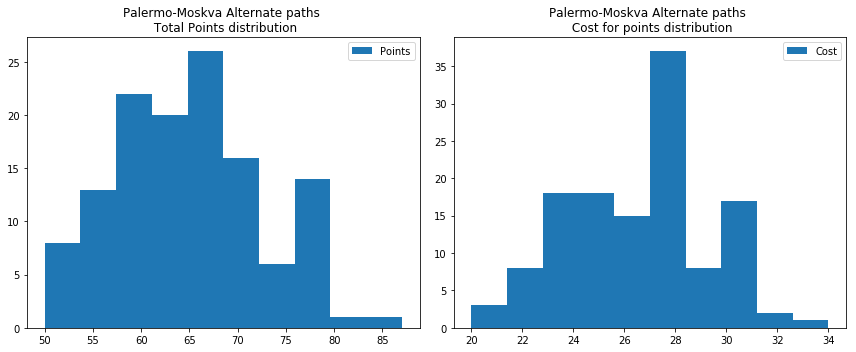

In [46]:
#histogram of all points for all alternate paths

fig = plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.hist([temp_df['path_total_points']], label="Points")
plt.legend(loc='upper right')
plt.title('Palermo-Moskva Alternate paths \n Total Points distribution')

plt.subplot(1, 2, 2)
plt.hist([temp_df['path_cost']], label="Cost")
plt.legend(loc='upper right')
plt.title('Palermo-Moskva Alternate paths \n Cost for points distribution')

plt.tight_layout()

In [47]:
temp_df.sort_values(['path_total_points'],ascending=False).head(5)

,path,path_length,path_cost,path_total_points,path_points_per_capita
23,"[Palermo, Smyrna, Constantinople, Sevastopol, Bucuresti, Budapest, Kyiv, Kharkov, Moskva]",9,34,87,2.56
13,"[Palermo, Smyrna, Angora, Constantinople, Bucuresti, Budapest, Kyiv, Kharkov, Moskva]",9,32,81,2.53
45,"[Palermo, Smyrna, Constantinople, Bucuresti, Budapest, Kyiv, Wilno, Petrograd, Moskva]",9,31,79,2.55
74,"[Palermo, Smyrna, Athina, Sarajevo, Zagrab, Budapest, Kyiv, Kharkov, Moskva]",9,31,79,2.55
71,"[Palermo, Smyrna, Athina, Sarajevo, Budapest, Kyiv, Wilno, Petrograd, Moskva]",9,31,79,2.55


In [48]:
temp_df.sort_values(['path_points_per_capita'],ascending=False).head(5)

,path,path_length,path_cost,path_total_points,path_points_per_capita
29,"[Palermo, Smyrna, Constantinople, Sevastopol, Rostov, Kharkov, Moskva]",7,22,60,2.73
47,"[Palermo, Smyrna, Constantinople, Bucuresti, Kyiv, Smolensk, Moskva]",7,20,54,2.70
46,"[Palermo, Smyrna, Constantinople, Bucuresti, Kyiv, Kharkov, Moskva]",7,23,62,2.70
42,"[Palermo, Smyrna, Constantinople, Bucuresti, Budapest, Kyiv, Kharkov, Moskva]",8,29,77,2.66
68,"[Palermo, Smyrna, Athina, Sarajevo, Budapest, Kyiv, Kharkov, Moskva]",8,29,77,2.66


In [49]:
# betweenness centrality

bc = nx.betweenness_centrality(G)
top_bc = dict(sorted(bc.items(), key=lambda x: x[1], reverse=True)[:5])
#print(json.dumps(top_bc, indent=4))

for k,v in top_bc.items():
    print('{} - {}'.format(k,v))

Frankfurt - 0.21109636740071516
Paris - 0.20014705369777835
Berlin - 0.19125180375180373
Kyiv - 0.18437449024405547
Marseille - 0.15295250643076733


In [50]:
nx.diameter(G)

9

In [51]:
ecc = nx.eccentricity(G)
ecc = dict(sorted(ecc.items(), key=lambda x: x[1], reverse=True))
print(json.dumps(ecc, indent=4))

{
    "Lisboa": 9,
    "Cadiz": 9,
    "Edinburgh": 9,
    "Erzurum": 9,
    "Sochi": 9,
    "Rostov": 9,
    "Moskva": 9,
    "Madrid": 8,
    "Barcelona": 8,
    "Brest": 8,
    "Dieppe": 8,
    "London": 8,
    "Angora": 8,
    "Sevastopol": 8,
    "Constantinople": 8,
    "Bucuresti": 8,
    "Kharkov": 8,
    "Smolensk": 8,
    "Petrograd": 8,
    "Sofia": 8,
    "Pamplona": 7,
    "Marseille": 7,
    "Paris": 7,
    "Bruxelles": 7,
    "Amsterdam": 7,
    "Smyrna": 7,
    "Kyiv": 7,
    "Wilno": 7,
    "Budapest": 7,
    "Riga": 7,
    "Stockholm": 7,
    "Palermo": 7,
    "Athina": 7,
    "Kobenhavn": 7,
    "Sarajevo": 7,
    "Brindisi": 7,
    "Warszawa": 6,
    "Danzig": 6,
    "Essen": 6,
    "Wien": 6,
    "Zagrab": 6,
    "Roma": 6,
    "Frankfurt": 6,
    "Zurich": 6,
    "Berlin": 5,
    "Venezia": 5,
    "Munchen": 5
}


In [52]:
#node clustering co-efficient for each city
ccoef = nx.clustering(G)
print(json.dumps(ccoef, indent=4))

{
    "Lisboa": 1.0,
    "Cadiz": 1.0,
    "Madrid": 0.3333333333333333,
    "Barcelona": 0.6666666666666666,
    "Pamplona": 0.4,
    "Marseille": 0.3,
    "Paris": 0.2857142857142857,
    "Brest": 0.6666666666666666,
    "Dieppe": 0.3333333333333333,
    "London": 0,
    "Bruxelles": 0.5,
    "Amsterdam": 0.3333333333333333,
    "Edinburgh": 0,
    "Erzurum": 0.3333333333333333,
    "Angora": 0.3333333333333333,
    "Sevastopol": 0.3,
    "Sochi": 0.6666666666666666,
    "Smyrna": 0.16666666666666666,
    "Constantinople": 0.3,
    "Rostov": 0.3333333333333333,
    "Bucuresti": 0.3,
    "Kharkov": 0,
    "Moskva": 0,
    "Kyiv": 0.2,
    "Smolensk": 0.3333333333333333,
    "Petrograd": 0.16666666666666666,
    "Wilno": 0.3,
    "Warszawa": 0.3,
    "Budapest": 0.3,
    "Riga": 0.3333333333333333,
    "Stockholm": 0,
    "Palermo": 0.3333333333333333,
    "Athina": 0.16666666666666666,
    "Sofia": 0.3333333333333333,
    "Danzig": 0.3333333333333333,
    "Kobenhavn": 0,
    "Essen": 

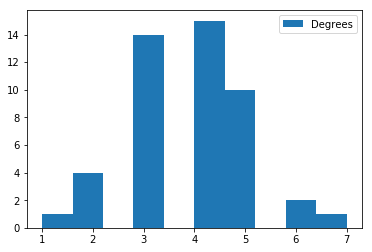

In [53]:
#histogram of degrees for all nodes
degree_list = [G.degree[n] for n in G.nodes(data=False)]

plt.hist(degree_list, label="Degrees")
plt.legend(loc='upper right')

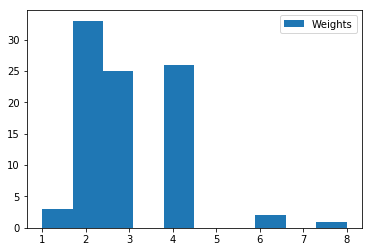

In [54]:
#histogram of weights for all nodes
weights_list = [d['weight'] for u,v,d in G.edges(data=True)]

plt.hist(weights_list, label="Weights")
plt.legend(loc='upper right')

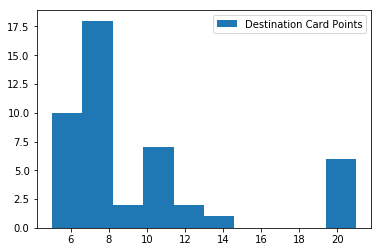

In [55]:
# histogram of destination cards points
card_points = [row['card_points'] for idx,row in destinations_df.iterrows()]

plt.hist(card_points, label="Destination Card Points")
plt.legend(loc='upper right')

In [56]:
# calc edge importance from min edge cut's
for idx,row in destinations_df.iterrows():
    for min_cut in list(nx.minimum_edge_cut(G,row['source'],row['destination'])):
        u, v = min_cut
        G.edges[u,v]['importance']+=1

In [57]:
for u, v, d in sorted(G.edges(data=True), key=lambda x: x[2]['importance'], reverse=True)[:10]:
    print('{u}-{v} {imp}'.format(u=u, v=v, imp=d['importance']))

Madrid-Pamplona 5
Petrograd-Stockholm 5
Pamplona-Brest 4
Moskva-Smolensk 4
Kobenhavn-Essen 4
Madrid-Barcelona 3
Barcelona-Marseille 3
Paris-Brest 3
Brest-Dieppe 3
Dieppe-London 3


In [58]:
# edge-betweenness centrality

ebc = nx.edge_betweenness_centrality(G,weight='weight')
top_ebc = dict(sorted(ebc.items(), key=lambda x: x[1], reverse=True)[:5])

for k,v in top_ebc.items():
    print('{} - {}'.format(k,v))

('Budapest', 'Wien') - 0.14287916831857628
('Zagrab', 'Venezia') - 0.1316726135412537
('Wien', 'Munchen') - 0.11743976036297961
('Frankfurt', 'Munchen') - 0.11262499449363465
('Bucuresti', 'Budapest') - 0.11036518215056604
